In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
# from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #


## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH

# Override default pprint
builtins.pprint = wide_pprint

text_formatter: PlainTextFormatter = IPython.get_ipython().display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
from pyphocorehelpers.programming_helpers import CodeConversion, SourceCodeParsing, GeneratedClassDefinitionType

# doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
# print(f"doc_output_parent_folder: {doc_output_parent_folder}")
# assert doc_output_parent_folder.exists()

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer, RankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses


# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

from silx.gui import qt
from silx.gui.plot import Plot2D, Plot1D
from silx.gui.colors import Colormap
from silx.gui.plot.items import ImageBase

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

# from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
# from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

from dotenv import load_dotenv
import os

load_dotenv()
# api_key = os.getenv('MY_API_KEY')

import cv2
import numpy as np
import fiftyone as fo

posterior_images_path = Path(r"C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\_temp_individual_posteriors\2024-08-13").resolve()
assert posterior_images_path.exists()
assert posterior_images_path.is_dir()



Automatic pdb calling has been turned OFF


In [2]:
import fiftyone.zoo as foz

## INPUTS: posterior_images_path
sample_dataset = foz.load_zoo_dataset("quickstart")
sample_session = fo.launch_app(sample_dataset)


Dataset already downloaded


INFO:fiftyone.zoo.datasets:Dataset already downloaded


Loading 'quickstart'


INFO:fiftyone.zoo.datasets:Loading 'quickstart'


 100% |█████████████████| 200/200 [1.6s elapsed, 0s remaining, 124.5 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 200/200 [1.6s elapsed, 0s remaining, 124.5 samples/s]         


Dataset 'quickstart' created


INFO:fiftyone.zoo.datasets:Dataset 'quickstart' created



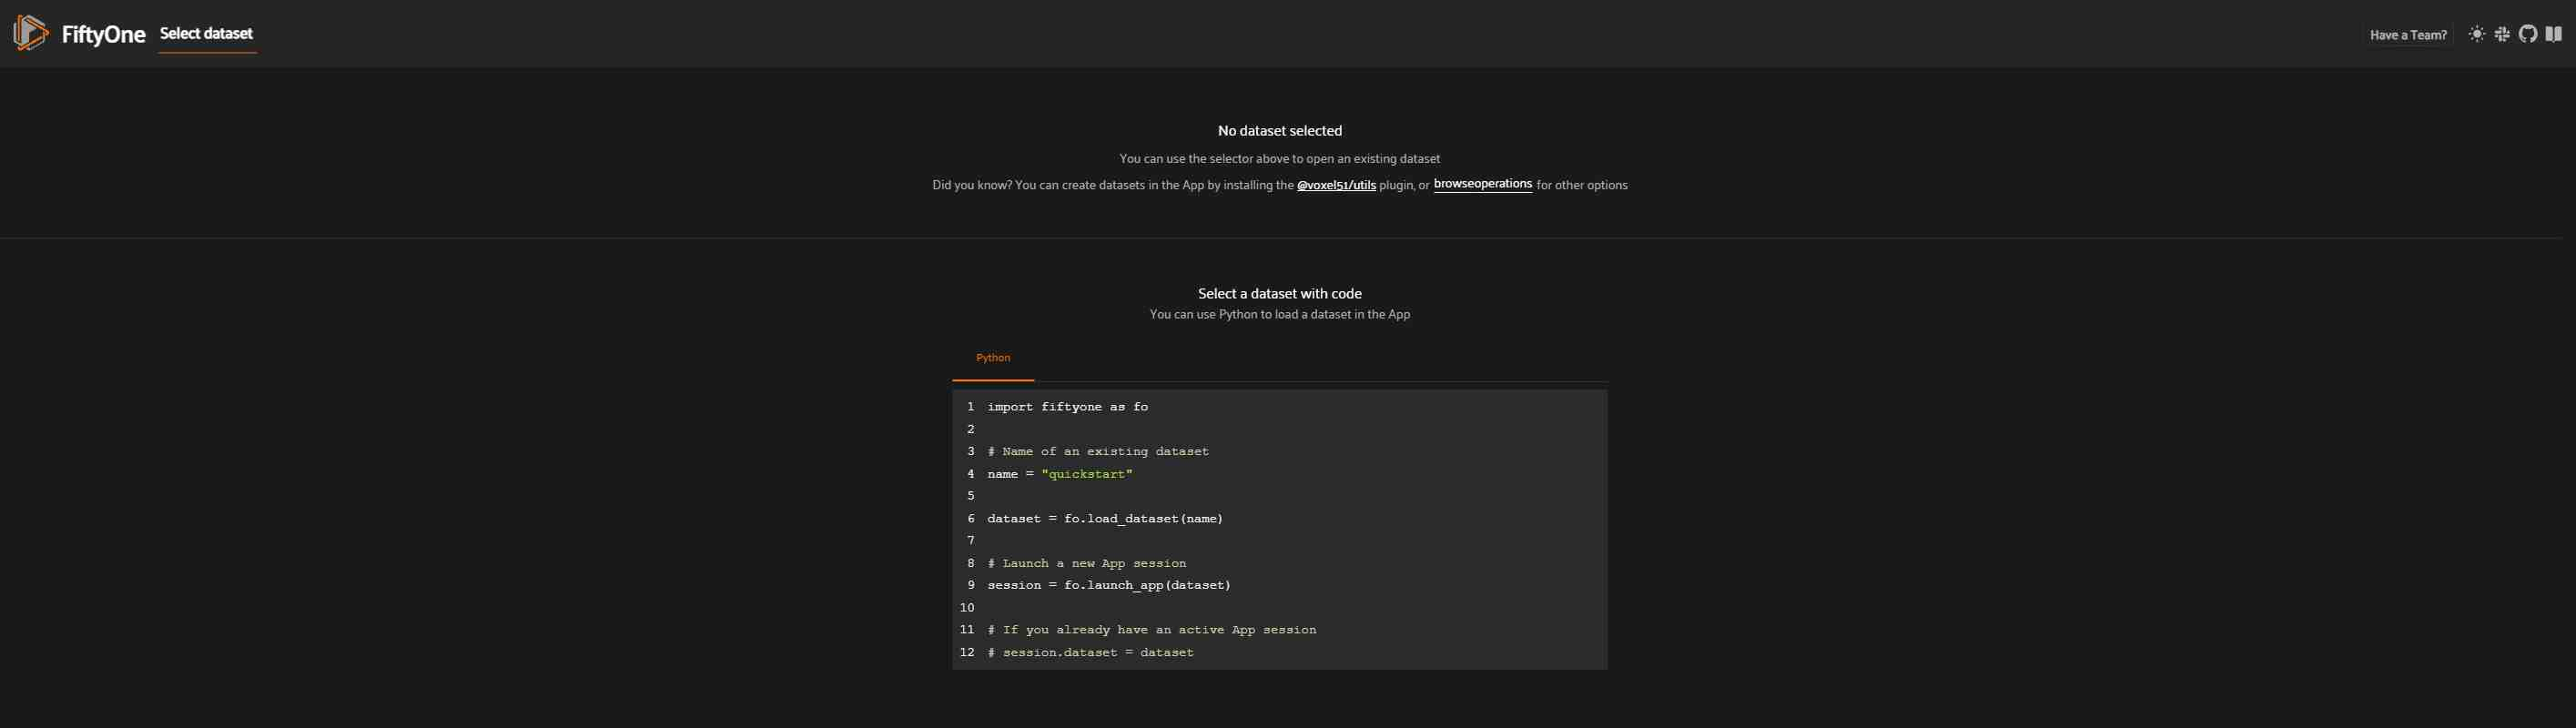

In [4]:
import fiftyone as fo

# session = fo.launch_app(desktop=True)
session = fo.launch_app(browser=True)

In [5]:

name = "test-exported-posteriors-dataset"
dataset_dir = posterior_images_path.resolve().as_posix()
debug_print = False
# dataset_dir = posterior_images_path.resolve().as_posix()
processed_images_folder = posterior_images_path.joinpath('processed').resolve()

# Check if the dataset already exists
if name in fo.list_datasets():
    dataset = fo.load_dataset(name)
else:
    # Create the dataset
    dataset = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.ImageDirectory,
        name=name,
    )    

# # View summary info about the dataset
# print(dataset)

# # Print the first few samples in the dataset
# print(dataset.head())


 100% |█████████████████| 336/336 [33.3ms elapsed, 0s remaining, 10.1K samples/s]  


INFO:eta.core.utils: 100% |█████████████████| 336/336 [33.3ms elapsed, 0s remaining, 10.1K samples/s]  


In [ ]:
session = fo.launch_app(dataset)

## Automatic screenshots as you work

Notebooks are great for many reasons, one of which is the ability to share your work with others. FiftyOne is designed to help you write notebooks that capture your work on visual datasets, using a feature we call **automatic screenshotting**.

Whenever you open a new App instance in a notebook cell, e.g., by updating your [Session](https://voxel51.com/docs/fiftyone/api/fiftyone.core.session.html#fiftyone.core.session.Session) object, any previous App instances will be automatically replaced with a static screenshot. In fact, that's what you're seeing below; screenshots of the Apps we opened when we created this notebook!

The cell below issues a [session.show()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.session.html#fiftyone.core.session.Session.show) command, which opens a new App instance in the cell's output. When you run the cell for yourself, notice that the App instance in the previous cell is automatically replaced with a screenshot of its current state. You can reactivate old App instances by hovering over them and clicking anywhere.

After running the cell below, try double-clicking on an image in the grid to expand the sample.

In [ ]:
session.show()


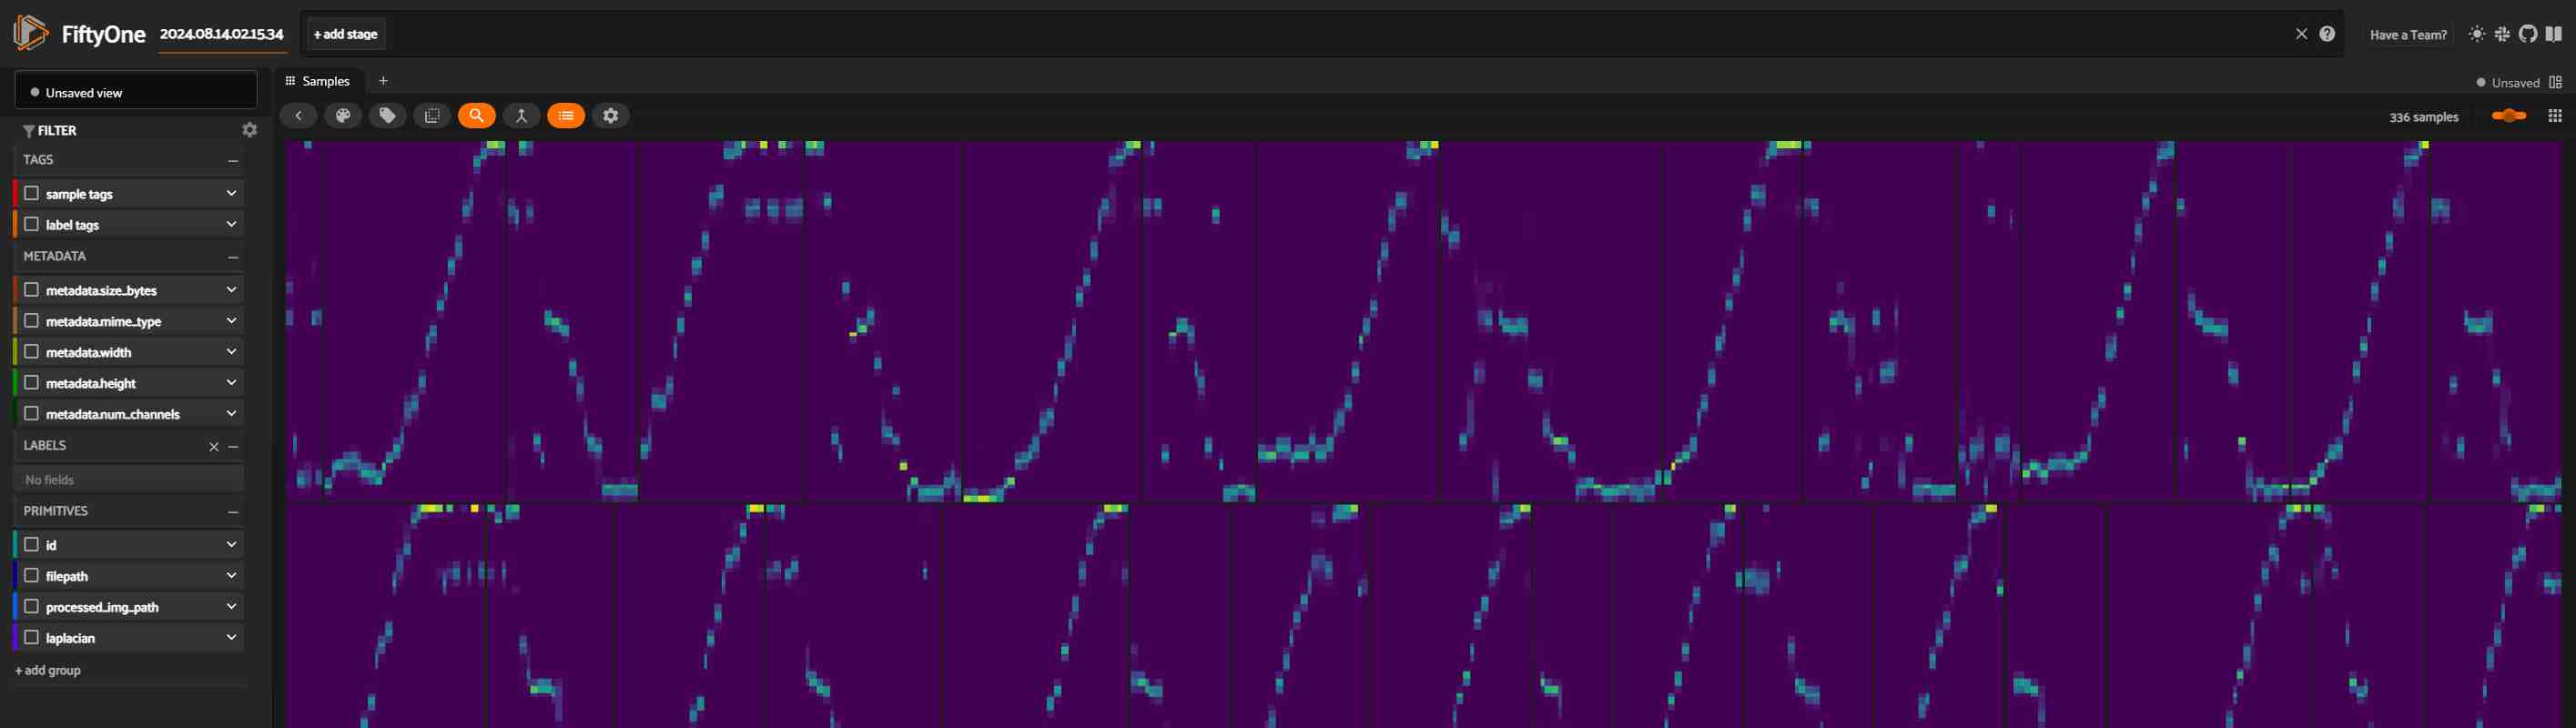

In [10]:
import cv2
import numpy as np



## INPUTS: dataset

def apply_laplacian(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply the Laplacian edge detector
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    
    # Convert back to uint8
    abs_laplacian = np.uint8(np.absolute(laplacian))
    
    return abs_laplacian



dataset2 = dataset.clone()
dataset2.add_sample_field("processed_img_path", fo.StringField)

# Apply the Laplacian edge detector to each image in the dataset
for sample in dataset2:
    # Get the file path of the image
    image_path = sample.filepath
    
    # Apply the Laplacian edge detector
    laplacian_image = apply_laplacian(image_path)
    
    raw_img_path = Path(image_path).resolve()
    # processed_img_path = processed_images_folder.joinpath(raw_img_path.name)
    processed_img_path = processed_images_folder.joinpath(f"{raw_img_path.stem}_laplacian").with_suffix(raw_img_path.suffix)
    if debug_print:
        print(f'image_path: {image_path}')
        print(f'processed_img_path: {processed_img_path}')
        
    # processed_img_path.with_suffix("_laplacian")
    # raw_img_path
    
    # # Save the result as a new image
    # output_path = image_path.replace(".jpg", "_laplacian.jpg")
    output_path = processed_img_path.as_posix()
    _is_success = cv2.imwrite(output_path, laplacian_image)
    
    # print(sample)
    sample["processed_img_path"] = output_path
    # Add the new image to the dataset
    sample["laplacian"] = output_path # fo.Image(filepath=output_path)
    sample.save()
    

session2 = fo.launch_app(dataset2)
session2.show()


In [11]:
def perform_laplacian_edge_detection(dataset, processed_images_folder, debug_print=False):
    _computation_id_key: str = "laplacian"
    
    def apply_laplacian(image_path):
        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply the Laplacian edge detector
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        
        # Convert back to uint8
        abs_laplacian = np.uint8(np.absolute(laplacian))
        
        return abs_laplacian


    dataset2 = dataset.clone()
    dataset2.add_sample_field("processed_img_path", fo.StringField)

    # Apply the Laplacian edge detector to each image in the dataset
    for sample in dataset2:
        # Get the file path of the image
        image_path = sample.filepath
        
        # Apply the Laplacian edge detector
        laplacian_image = apply_laplacian(image_path)
        
        raw_img_path = Path(image_path).resolve()
        # processed_img_path = processed_images_folder.joinpath(raw_img_path.name)
        processed_img_path = processed_images_folder.joinpath(f"{raw_img_path.stem}_{_computation_id_key}").with_suffix(raw_img_path.suffix)
        if debug_print:
            print(f'image_path: {image_path}')
            print(f'processed_img_path: {processed_img_path}')
            
        # processed_img_path.with_suffix("_laplacian")
        # raw_img_path
        
        # # Save the result as a new image
        # output_path = image_path.replace(".jpg", "_laplacian.jpg")
        output_path = processed_img_path.as_posix()
        _is_success = cv2.imwrite(output_path, laplacian_image)
        
        # print(sample)
        sample["processed_img_path"] = output_path
        # Add the new image to the dataset
        sample[_computation_id_key] = output_path # fo.Image(filepath=output_path)
        sample.save()
        
    return dataset2

dataset2 = perform_laplacian_edge_detection(dataset, processed_images_folder=processed_images_folder, debug_print=False)
# session2 = fo.launch_app(dataset2)
# session2.show()


In [ ]:
import cv2


def perform_ridge_detection(dataset, processed_images_folder, debug_print=False):
    _computation_id_key: str = "ridges"
    
    def apply_ridge_detection(image_path):
        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply the ridge detection filter
        ridge_filter = cv2.ximgproc.RidgeDetectionFilter_create()
        ridges = ridge_filter.getRidgeFilteredImage(gray)
        
        # Convert back to uint8
        abs_ridges = np.uint8(np.absolute(ridges))
        
        return abs_ridges


    dataset2 = dataset.clone()

    # Apply the Ridge Detection Filter to each image in the dataset
    for sample in dataset2:
        # Get the file path of the image
        image_path = sample.filepath
        
        # Apply the ridge detection
        ridges_image = apply_ridge_detection(image_path)
        
        raw_img_path = Path(image_path).resolve()
        # processed_img_path = processed_images_folder.joinpath(raw_img_path.name)
        processed_img_path = processed_images_folder.joinpath(f"{raw_img_path.stem}_{_computation_id_key}").with_suffix(raw_img_path.suffix)
        if debug_print:
            print(f'image_path: {image_path}')
            print(f'processed_img_path: {processed_img_path}')
            
        # processed_img_path.with_suffix("_laplacian")
        # raw_img_path
        
        # # Save the result as a new image
        # output_path = image_path.replace(".jpg", "_laplacian.jpg")
        output_path = processed_img_path.as_posix()
        _is_success = cv2.imwrite(output_path, ridges_image)
        
        # print(sample)
        sample["processed_img_path"] = output_path
        # Add the new image to the dataset
        sample[_computation_id_key] = output_path # fo.Image(filepath=output_path)
        sample.save()

    return dataset2

dataset3 = perform_ridge_detection(dataset, processed_images_folder=processed_images_folder, debug_print=False)
# session3 = fo.launch_app(dataset3)
# session3.show()


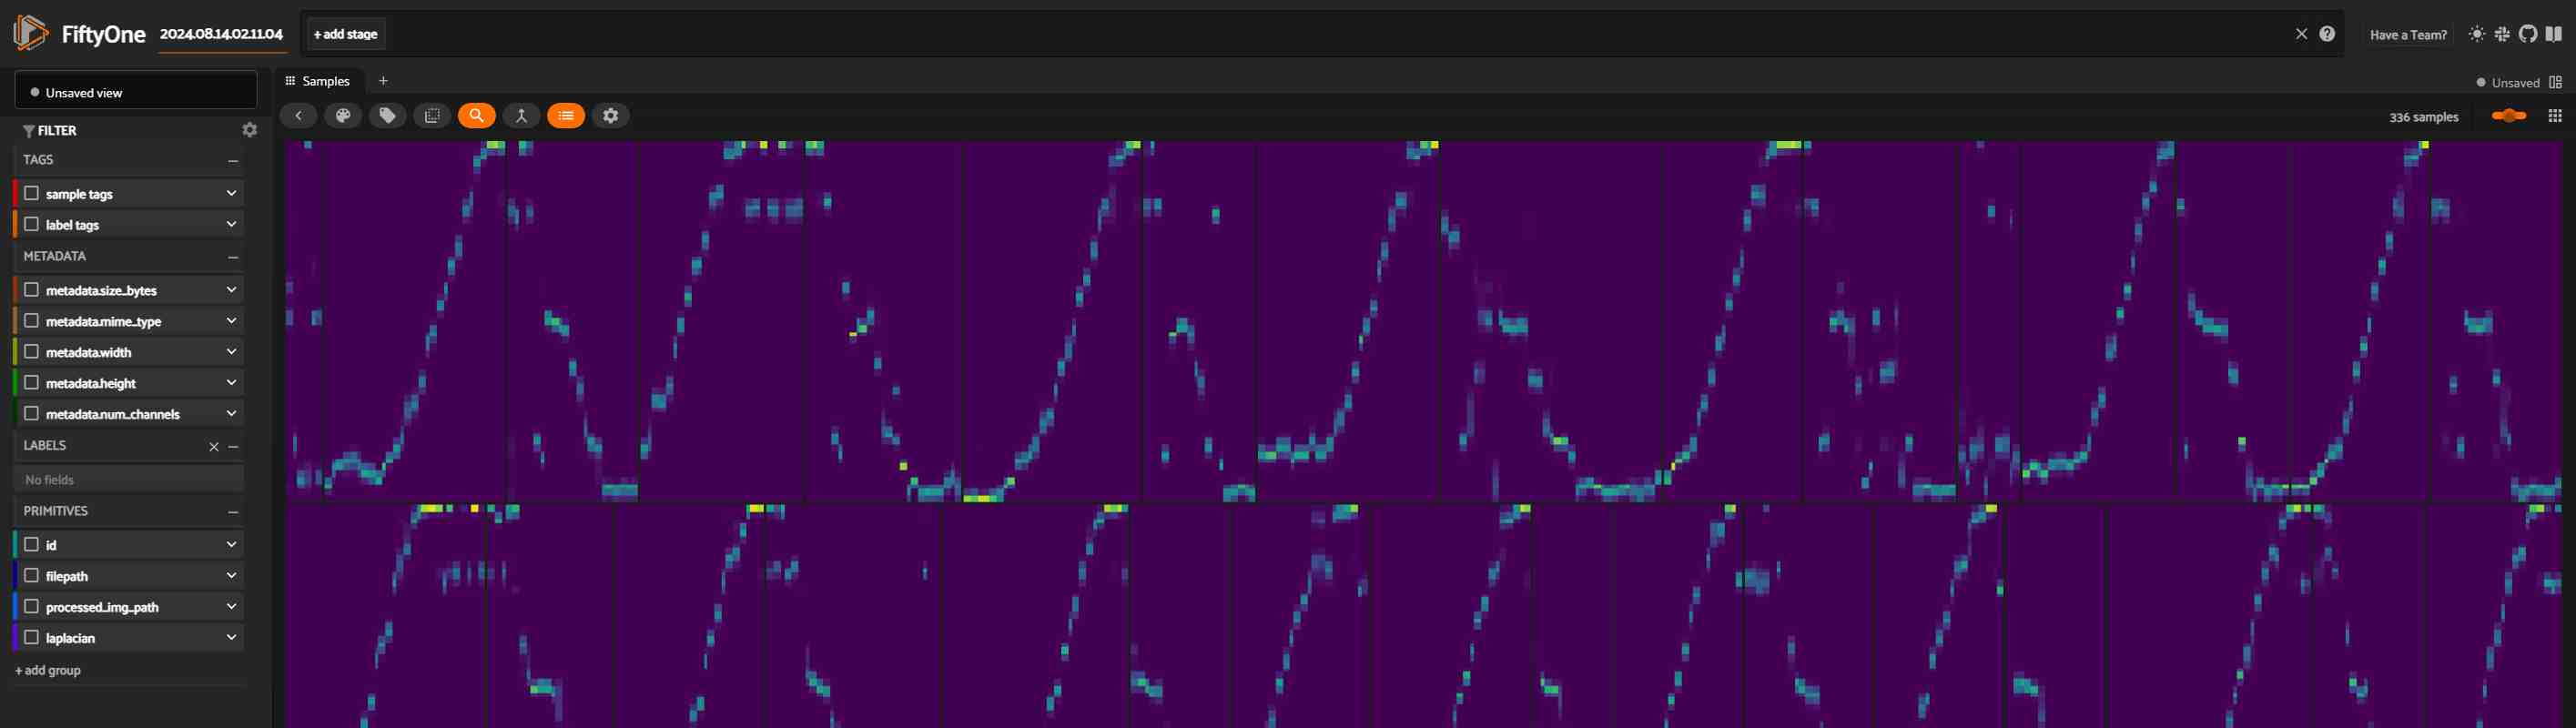

In [8]:
session.dataset = dataset2

In [ ]:


import requests


api_key = 'swBzQ0x.72AzLyKaC3DNvFSbrDHN4FwOaB1PGU7P'

json = {"name": "My Dataset"}
headers = {"Authorization": f"ApiKey {api_key}"}
url = "https://darwin.v7labs.com/api/datasets"

result = requests.post(url, json=json, headers=headers)
print(result.json())


In [ ]:

processed_ds_name = "test-exported-posteriors-processed-dataset"
processed_dataset_dir = processed_images_folder.resolve().as_posix()

# Check if the dataset already exists
if processed_ds_name in fo.list_datasets():
    processed_dataset = fo.load_dataset(processed_ds_name)
else:
    # Create the dataset
    processed_dataset = fo.Dataset.from_dir(
        dataset_dir=processed_dataset_dir,
        dataset_type=fo.types.ImageDirectory,
        name=processed_ds_name,
    )    

# View summary info about the dataset
print(processed_dataset)

# Print the first few samples in the dataset
print(processed_dataset.head())

session2 = fo.launch_app(processed_dataset)
# session2.show()
session2


## Dataset Views

The power of FiftyOne truly comes alive when using [dataset views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html).

Think of a [Dataset](https://voxel51.com/docs/fiftyone/api/fiftyone.core.dataset.html#fiftyone.core.dataset.Dataset) as the root view into your all of your data. Creating a [DatasetView](https://voxel51.com/docs/fiftyone/api/fiftyone.core.view.html#fiftyone.core.view.DatasetView) allows you to study a specific subset of the samples and/or fields of your dataset.

Dataset views can be created and modified both in Python and in the App. The active view in the App is always available via the [Session.view](https://voxel51.com/docs/fiftyone/api/fiftyone.core.session.html#fiftyone.core.session.Session.view) property of your session. This means that if you update your view in the App, its state will be captured by [Session.view](https://voxel51.com/docs/fiftyone/api/fiftyone.core.session.html#fiftyone.core.session.Session.view). Or, you can create a view programmatically in Python and open it in the App by setting the [Session.view](https://voxel51.com/docs/fiftyone/api/fiftyone.core.session.html#fiftyone.core.session.Session.view) property.

Let's start by creating a view into our dataset via the App. We'll sort the dataset by the `uniqueness` field to show the most unique images first. To do this, we will click `+ add stage` in the View Bar and add a `SortBy` stage with `uniqueness` as the field, and `reverse` equal to `True`.

In [ ]:
session.show()

We can then access the view in Python and, for example, print the most unique sample:

In [ ]:
print(session.view.first())

## Complex views in Python

Sometimes you may be interested in creating a [complex view](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#view-stages) into a dataset that is specified by a series of conditions or complex filtering operations.

You can achieve this in FiftyOne by [chaining view stages](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#tips-tricks) together to define the view you want.

As an example, let's create a view that contains only the 25 most unique samples in the dataset, and only predictions on those samples with confidence > 0.5.

Remember that, because we are working in a notebook, any time we change our [Session](https://voxel51.com/docs/fiftyone/api/fiftyone.core.session.html#fiftyone.core.session.Session) object, a new App will be displayed in the cell's output.

In [ ]:
from fiftyone import ViewField as F

session.view = (
    dataset
    .sort_by("uniqueness", reverse=True)
    .limit(25)
    .filter_labels("predictions", F("confidence") > 0.5)
)

In [ ]:
# Evaluate the objects in the `predictions` field with respect to the
# objects in the `ground_truth` field
results = sample_dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_predictions",
)
sample_session.show()

# # Detection evaluation
# dataset.evaluate_detections(
#     "predictions",
#     gt_field="ground_truth",
#     eval_key=eval_key,
#     ...,
# )


## Further reading

This quickstart touched on only a few of the possibilities of using FiftyOne. If you'd like to learn more, check out these [tutorials](https://voxel51.com/docs/fiftyone/tutorials/index.html) and [recipes](https://voxel51.com/docs/fiftyone/recipes/index.html) to see more concrete use cases and best practices.

And did we mention that FiftyOne is open source? Check out the project [on GitHub](https://github.com/voxel51/fiftyone) and [leave an issue](https://github.com/voxel51/fiftyone/issues/new/choose) if you think something is missing.

Thanks for tuning in!

# Plugins

In [ ]:
fiftyone plugins download https://github.com/voxel51/fiftyone-plugins --plugin-names @voxel51/evaluation
fiftyone plugins download https://github.com/voxel51/fiftyone-plugins --plugin-names @voxel51/annotation
fiftyone plugins download https://github.com/voxel51/fiftyone-plugins --plugin-names @voxel51/io

## Community
# fiftyone plugins download https://github.com/voxel51/fiftyone-plugins --plugin-names @voxel51/evaluation @voxel51/annotation @voxel51/io @danielgural/outlier_detection @jacobmarks/clustering @danielgural/clustering_algorithms

fiftyone plugins download https://github.com/danielgural/outlier_detection
fiftyone plugins download https://github.com/danielgural/clustering_algorithms
fiftyone plugins download https://github.com/jacobmarks/clustering-plugin


In [ ]:
# List all plugins you've downloaded
fiftyone plugins list

# List the available operators
fiftyone operators list


# Testing Annotations with Darwin V7
https://darwin.v7labs.com/datasets

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")
view = dataset.take(1)

anno_key = "v7_new_field"

view.annotate(
    anno_key,
    backend="darwin",
    label_field="new_classifications",
    label_type="classifications",
    classes=["dog", "cat", "person"],
    dataset_slug=anno_key,
    launch_editor=True,
)
print(dataset.get_annotation_info(anno_key))

# Create annotations in V7

dataset.load_annotations(anno_key, cleanup=True)
dataset.delete_annotation_run(anno_key)

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")
view = dataset.take(1)

anno_key = "v7_new_field"

label_schema = {
    "new_classifications": {
        "type": "classifications",
        "classes": ["dog", "cat", "person"],
    }
}

view.annotate(
    anno_key,
    backend="darwin",
    label_schema=label_schema,
    dataset_slug=anno_key,
    launch_editor=True,
)
print(dataset.get_annotation_info(anno_key))

# Create annotations in V7

dataset.load_annotations(anno_key, cleanup=True)
dataset.delete_annotation_run(anno_key)